### Assumptions Prior to Using This Module 

1. To use "balanced" data set, please run Analyzer to generate the dataset first (it may take about 30 mins)
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c-balanced.csv
   
2. To use regular data (the sampled dataset from Andromeda), there's nothing you need to do.
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c.csv
   

In [1]:
import pandas as pd 
from pandas import DataFrame, Series
import os, sys, re
import numpy as np
from decimal import Decimal
from utils_sys import highlight

import warnings
warnings.filterwarnings('ignore')  # action='once'

# local modules
from analyzer import load_data, save_data, load_performance
import loinc as lc

%matplotlib inline

### Determine Target Cohort

In [2]:
cohort = 'hepatitis-c'

### Define Feature Set

In [3]:
"""
Memo
----
1. medivo_test_result_type is a function of the following attributes: 
      "meta_sender_name",
      "receiving_organization_id",
      "test_order_code",
      "test_order_name",
      "test_result_code",
      "test_result_name",
      "test_result_loinc_code",
      "test_result_units_of_measure"
      
"""
from analyzer import sample_col_values
from loinc import FeatureSet

cat_cols = FeatureSet.cat_cols  # 22 vars
cont_cols = FeatureSet.cont_cols  # e.g. age
derived_cols = FeatureSet.derived_cols
# ... ['count']  # other possible vars: test result n-th percentile, normalized test frequency

target_cols = FeatureSet.target_cols  # ['test_result_loinc_code', ]

# cardinality < 100
low_card_cols = FeatureSet.low_card_cols # ['patient_gender', 'fasting', 'meta_sender_name' ]
high_card_cols = FeatureSet.high_card_cols

target_columns = cat_cols + cont_cols + target_cols

### Load (Curated) Training Data

note: Training data was saved prior to the variable encoding

In [4]:
from analyzer import load_src_data, analyze_values

# input_file = f"andromeda-pond-{cohort}.csv" # or f"andromeda-pond-{cohort}-balanced.csv"
# ts = load_data(input_file=input_file, warn_bad_lines=False)
ts = load_src_data(cohort=cohort, warn_bad_lines=False, canonicalized=True, processed=True)

print("(load) dim(df): {} | columns:\n{}\n".format(ts.shape, 
        list(ts.columns.values[:10])+['...']+list(ts.columns.values[-10:]))) 
# ... 'ts' at this point contains all variables

# check feature values
analyze_values(ts, cols=cat_cols, topn=10)  # topn: most common n feature values (and their counts)

[load] Loading default input data: andromeda-pond-hepatitis-c.csv
(canonicalize) Operations: fill n/a + dehyphenate + replace_values + trim_tail + fill others (non-target classes)
(load) dim(df): (71224, 127) | columns:
['meta_package_key', 'input_filename', 'patient_date_of_birth', 'patient_gender', 'patient_state', 'patient_bill_type', 'diagnosis_codes', 'diagnosis_descriptions', 'laboratory_diagnosis', 'billing_diagnosis_codes', '...', 'meta_dict_orig', 'meta_dict_final', 'meta_ingestion_datetime', 'meta_original_filename', 'meta_sender_name', 'meta_sender_source', 'meta_sender_type', 'meta_sender_dataset', 'meta_sender_ver', 'medivo_test_result_type']

[1] name: patient_gender => values: 
[('M', 42620), ('F', 28555), (nan, 49)]
 ... mode: M
[2] name: patient_state => values: 
[('CA', 9616), ('TX', 8828), ('FL', 7549), ('NY', 5827), ('PA', 4453), ('NJ', 3864), ('MD', 3269), ('GA', 1902), ('NC', 1675), ('TN', 1556)]
 ... mode: CA
[3] name: patient_bill_type => values: 
[('PI', 18695)

{'patient_gender': [('M', 42620), ('F', 28555), (nan, 49)],
 'patient_state': [('CA', 9616),
  ('TX', 8828),
  ('FL', 7549),
  ('NY', 5827),
  ('PA', 4453),
  ('NJ', 3864),
  ('MD', 3269),
  ('GA', 1902),
  ('NC', 1675),
  ('TN', 1556)],
 'patient_bill_type': [('PI', 18695),
  ('PRIVATE INSURANCE', 14270),
  ('CM', 10032),
  (nan, 8672),
  ('MC', 5098),
  ('MEDICARE', 4390),
  ('MEDICAID', 2668),
  ('MD', 2549),
  ('MANAGE CARE FFS', 2436),
  ('CLIENT', 1161)],
 'fasting': [(nan, 61446),
  ('NOT FASTING', 3942),
  ('Y', 1986),
  ('N', 1334),
  ('U', 1269),
  ('FASTING', 1247)],
 'performing_organization_id': [(nan, 29269),
  ('BN', 13666),
  ('RN', 5484),
  ('CPLSW', 4374),
  ('SO', 2292),
  ('CB', 2118),
  ('TA', 1973),
  ('MB', 1743),
  ('DA', 1267),
  ('PDLCA', 1227)],
 'receiving_organization_id': [(nan, 37380),
  ('CPLSW', 4374),
  ('22', 3660),
  ('28', 3054),
  ('17', 3024),
  ('1', 2727),
  ('15', 2360),
  ('35', 1579),
  ('30', 1529),
  ('41', 1370)],
 'test_result_status': [(

### Feature Transformation
note: patient_date_of_birth => age

In [5]:
from transformer import to_age
from analyzer import col_values
from loinc import FeatureSet

tTransformed = False

FeatureSet.to_age(ts)
values = col_values(ts, col='age', n=10)
print("> age: {}".format(values))

# datatime columns

> age: [71 61 69 72 59 71 69 68 62 69]


### Subset Variables, Encode Variables and Handling Missing Values

In [6]:
from analyzer import feature_transform

regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)
highlight("Found {} reg vars | {} label vars".format(len(regular_vars), len(target_vars)))
msg = ""
msg += "... regular_vars:  {}\n".format(regular_vars)
msg += "... target vars:   {}\n".format(target_vars)
msg += "... derived vars:  {}\n".format(derived_vars)
msg += "... meta_vars:     {}\n".format(meta_vars)
print(msg)

ts = feature_transform(ts, drop_high_missing=False, pth_null=0.9, verbose=1)

Found 23 reg vars | 1 label vars
... regular_vars:  ['patient_gender', 'patient_state', 'patient_bill_type', 'fasting', 'performing_organization_id', 'receiving_organization_id', 'test_result_status', 'test_order_code', 'test_order_name', 'test_result_code', 'test_result_name', 'test_result_value', 'test_result_range', 'test_result_abnormal_flag', 'test_result_reference_range', 'test_result_units_of_measure', 'test_result_comments', 'test_cpt_code', 'panel_order_code', 'panel_order_name', 'meta_sender_name', 'medivo_test_result_type', 'age']
... target vars:   ['test_result_loinc_code']
... derived vars:  []
... meta_vars:     []

[transform] age: [71 61 69 72 59 71 69 68 62 69]
(encoder_vars2) low card vars (n=['patient_gender', 'meta_sender_name', 'fasting']):
3
 ... high card vars (n=['test_result_comments', 'panel_order_code', 'test_result_value', 'patient_bill_type', 'test_result_units_of_measure', 'test_cpt_code', 'test_order_code', 'patient_state', 'test_result_reference_range',

### Partition Variables

In [7]:
from analyzer import encode_labels, summarize_dict, get_sample_sizes
import collections, operator

codebook={'pos': 1, 'neg': 0, '+': 1, '-': 0}

tsX, tsY, ts_derived, ts_meta = FeatureSet.partition(ts)

print("> Found n(X)={}, n(Y)={}, n(Derived)={}, n(Meta):{}".format(
    tsX.shape[1], tsY.shape[1], ts_derived.shape[1], ts_meta.shape[1]))

# verify
assert tsX.shape[0] == tsY.shape[0]

[partition] 204 reg vars | 1 label vars
... regular_vars (X): ['patient_gender_1', 'patient_gender_2', 'patient_gender_3', 'patient_state_0', 'patient_state_1', 'patient_state_2', 'patient_state_3', 'patient_state_4', 'patient_state_5', 'patient_state_6', 'patient_bill_type_0', 'patient_bill_type_1', 'patient_bill_type_2', 'patient_bill_type_3', 'patient_bill_type_4', 'fasting_1', 'fasting_2', 'fasting_3', 'fasting_4', 'fasting_5', 'fasting_6', 'performing_organization_id_0', 'performing_organization_id_1', 'performing_organization_id_2', 'performing_organization_id_3', 'performing_organization_id_4', 'performing_organization_id_5', 'performing_organization_id_6', 'performing_organization_id_7', 'performing_organization_id_8', 'receiving_organization_id_0', 'receiving_organization_id_1', 'receiving_organization_id_2', 'receiving_organization_id_3', 'receiving_organization_id_4', 'receiving_organization_id_5', 'receiving_organization_id_6', 'test_result_status_0', 'test_result_status_1'

### Model Training

In [8]:
import utils_tree, utils_sys, analyzer
import collections
from analyzer import balance_by_downsampling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from loinc import TSet, FeatureSet, LoincTSet
from common import apply_scaling

def get_sample_size(y, code_book={}):
    if not code_book: code_book = TSet.codebook
    counter = collections.Counter(y)
    return (counter[codebook['neg']], counter[codebook['pos']])

# model training parameters 
n_fold = 5
n_min = n_fold  # min number of examples to train a classifier
scaling_method = 'minmax'
tBalance = True   # balance the data set? If True, will attempt to limit the sample size of the majority class

# data transformation
col_target = LoincTSet.col_target  # 'test_result_loinc_name'
# regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)

X, y = tsX.values, tsY.values.flatten()
loinc_set = raw_labels = np.unique(y)
print("> dim(X): {}, sample(y): {}".format(X.shape, np.random.choice(loinc_set,20) ))

# feature scaling
X = apply_scaling(X, scaler=scaling_method)

# attributes for performance data
header = ['code', 'mean', 'std', 'n_pos', 'total']
sdict = {h:[] for h in header}
for code in loinc_set: 
    y_bin = analyzer.encode_labels(y, pos_label=code)
    
    n_neg, n_pos = get_sample_size(y_bin)
    print(f"... Code: {code} | sample size | n0(+): {n_pos}, n0(-): {n_neg}")
    
    if n_pos >= n_min: 
        
        # additional step to balance control sample size (in 1-vs-all, the 'other' class tends to be too large)
        if tBalance: 
            X_eff, y_eff = balance_by_downsampling(X, y_bin, method='multiple', majority_max=10)
            assert isinstance(y_eff, np.ndarray) and isinstance(X_eff, np.ndarray)
        else: 
            X_eff, y_eff = X, y_bin
        
        n_neg, n_pos = get_sample_size(y_eff)
        
        # training + evaluation (default classifier: logistic regression)
        scores = analyzer.eval_performance(X_eff, y_eff, model=None, cv=n_fold, random_state=53, verbose=1)
        # metric: f1 score
        
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print("... average Fmax: {}, std: {}".format(mean_score, std_score))
    else: 
        print("> (positive) sample size too small, n={}".format(n_pos))
        mean_score = -1 
        std_score = -1
    sdict['code'].append(code)
    sdict['mean'].append(mean_score)
    sdict['std'].append(std_score)
    sdict['n_pos'].append(n_pos)
    sdict['total'].append(n_pos+n_neg)

# --------------------------------------------------
# save performance dataframe
df_perf = DataFrame(sdict, columns=header)
df_perf = df_perf.sort_values(by=['mean', ]) # ascending=False
analyzer.save_performance(df_perf, output_dir='result', cohort=cohort, verbose=1)  # other opts: output_file
# ... default sep: '|' but NOT ',' 


> dim(X): (71224, 204), sample(y): ['110510' '148049' '139956' '502211' '384453' '19885' '264507' '18093'
 '31682' '159756' '611517' '204545' '52092' '81224' '254284' '487934'
 '25320' '771477' '302398' '597054']
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 005025 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 10058 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 103317 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 103341 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71209, 1: 15})
... Code: 104661 | sample size | n0(+): 15, n0(-): 71209
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | 

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.939422615835653 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.7063499432228704 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8929190141875848 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9852800116931102 | F1: 0.9859154929577464, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9761514857623523 | F1: 0.9855072463768115, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 112771 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71218, 1: 6})
... Code: 112821 | sample size | n0(+): 6, n0(-): 71218
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.976239320666326 | F1: 1.0, A

> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9803967625435347 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9560635328023965 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9799788104557952 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9791373754291451 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 138016 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 139451 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71200, 1: 24})
... Code: 139501 | sample size | n0(+): 24, n0(-): 71200
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9024997847766261 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9882349426142423 | F1: 0.909090

(encode_labels) sample size: Counter({0: 71214, 1: 10})
... Code: 143149 | sample size | n0(+): 10, n0(-): 71214
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7850436265360354 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9807351109664151 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9550081884380099 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.4953831307051443 | F1: 0.6666666666666666, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9937173623860751 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71215, 1: 9})
... Code: 143164 | sample size | n0(+): 9, n0(-): 71215
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9846518279013783 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.90996154

... Code: 161927 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 162057 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 162289 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 162297 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 162339 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 162354 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 162370 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=

... Code: 178111 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 178137 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 178152 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 178194 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71217, 1: 7})
... Code: 17830 | sample size | n0(+): 7, n0(-): 71217
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9876138784861184 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.981453195419972 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9827434908583031 | F1: 1.0, AUC: 1.0

(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 183962 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 18416 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 70763, 1: 461})
... Code: 18697 | sample size | n0(+): 461, n0(-): 70763
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 0.9945945945945946 p_th: 0.8185143585855676 | F1: 0.9945945945945946, AUC: 0.9999650129452102
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9579410588852257 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8865976551575961 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.994535519125683 p_th: 0.7349043023758366 | F1: 0.994535519125683, AUC: 0.9999646326511364
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9611068721785938 | F1: 0.989247311827957, AUC: 

> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 19620 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71142, 1: 82})
... Code: 19638 | sample size | n0(+): 82, n0(-): 71142
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9916964187519681 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9955564721005957 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.9333333333333333 p_th: 0.9929798694852849 | F1: 0.9333333333333333, AUC: 0.9870426829268293
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9902430481352715 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9928153092651301 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9866666666666667, std: 0.02666666666666666
(encode_labels) sample size: Counter({0: 71220, 1: 4})
... Code: 196428 | sample size | n0(+): 4, n0(-)

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9887694515050294 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9551814645131358 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9876696148361827 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9912581650536771 | F1: 0.9411764705882353, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9907823118853789 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71169, 1: 55})
... Code: 203935 | sample size | n0(+): 55, n0(-): 71169
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9939296282876676 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9878859970944457 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9923744150527957 | F1: 1.0, AUC: 1.0
> 3 of KFo

... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9912559377096395 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9823604066431558 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9879769276384867 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9911407779054194 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8032118133485581 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 205211 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 205450 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71214, 1: 10})
... Code: 205674 | sample size | n0(+): 10, n0(-): 71214
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> 

... Code: 21600 | sample size | n0(+): 2029, n0(-): 69195
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.39366064765388703 | F1: 0.9987669543773119, AUC: 0.9999999999999999
> 1 of KFold 5
> Fmax: 0.998769987699877 p_th: 0.812758318619016 | F1: 0.9975429975429976, AUC: 0.9999981791122322
> 2 of KFold 5
> Fmax: 0.998769987699877 p_th: 0.5404843374012589 | F1: 0.998769987699877, AUC: 0.9999993930374107
> 3 of KFold 5
> Fmax: 0.9975308641975309 p_th: 0.9654109203588861 | F1: 0.9963008631319359, AUC: 0.9999010650979516
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7525987012822414 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9990141679194571, std: 0.0009233815758183144
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 216135 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71105, 1: 119})
... Code: 21618 | sa

> 1 of KFold 5
> Fmax: 1.0 p_th: 0.91693091248216 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9804881914267202 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.8963373340973257 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9693702459192644 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 23390 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71055, 1: 169})
... Code: 23457 | sample size | n0(+): 169, n0(-): 71055
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9486962675490543 | F1: 0.9855072463768115, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9855072463768115 p_th: 0.8875172042982593 | F1: 0.9714285714285714, AUC: 0.9998259658893143
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.7991909984926456 | F1: 1.0, AUC: 1.0
> 3 of KFold 5


... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7374913266264688 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8349961085405201 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9860583680735001 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.8701650558326112 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8719152910956209 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71102, 1: 122})
... Code: 25015 | sample size | n0(+): 122, n0(-): 71102
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9693431937325211 | F1: 0.9803921568627451, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9795918367346939 p_th: 0.9740909337388018 | F1: 0.9795918367346939, AUC: 0.999344262295082
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.3976461869993402 | F1: 0.9787234042553191, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9858640803317964 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9923518831973812 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9827168761961791 | F1: 0.9696969696969697, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9944587039462337 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9847831114629131 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 264663 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71216, 1: 8})
... Code: 264747 | sample size | n0(+): 8, n0(-): 71216
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 0.8 p_th: 0.4465755886727015 | F1: 0.5, AUC: 0.96875
>

> Fmax: 1.0 p_th: 0.8740419588115347 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9892576703843007 | F1: 0.888888888888889, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9217224639989723 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9326767628598723 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71209, 1: 15})
... Code: 273532 | sample size | n0(+): 15, n0(-): 71209
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9885362894344313 | F1: 0.8571428571428571, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.7843571322175832 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.2712772091435425 | F1: 0.8, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9820811187961274 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8800126239804383 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Count

> Fmax: 1.0 p_th: 0.753366514580292 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.65364378071462 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9536854321781867 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.982129206956602 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 70945, 1: 279})
... Code: 28852 | sample size | n0(+): 279, n0(-): 70945
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9722284129776332 | F1: 0.9911504424778761, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9577345224091759 | F1: 0.9655172413793104, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9301265574227678 | F1: 0.9911504424778761, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9909909909909909 p_th: 0.9304674104150635 | F1: 0.9821428571428571, AUC: 0.9999359959037378
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8830110041443523 | F1: 0.9909909909909909, AU

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7195384958580098 | F1: 0.9803921568627451, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8993679532458833 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9709453361982541 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9580309448628007 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.5892807957607444 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 302117 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71217, 1: 7})
... Code: 302398 | sample size | n0(+): 7, n0(-): 71217
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9705304826693091 | F1: 1.0, AUC: 1.0
> 1 o

(encode_labels) sample size: Counter({0: 71206, 1: 18})
... Code: 304519 | sample size | n0(+): 18, n0(-): 71206
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9892242784856463 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9665956237223605 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9945491662406051 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9778299060691543 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9731832968348133 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 304717 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 30494 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 30

... Code: 312041 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71219, 1: 5})
... Code: 312082 | sample size | n0(+): 5, n0(-): 71219
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.8742143056027406 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9288766250536509 | F1: 0.6666666666666666, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9175923055065007 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9734606100599597 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.5 p_th: 0.0396546142609579 | F1: 0.0, AUC: 0.8
... average Fmax: 0.9, std: 0.2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 312900 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71211, 1: 13})
... Code: 31377 | sample size | n0(+): 13, n0(-): 71

> Fmax: 1.0 p_th: 0.9973737750358302 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8830536374896872 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.995792500097096 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9848376992984061 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.1778555746343734 | F1: 0.923076923076923, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 32987 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 329987 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71197, 1: 27})
... Code: 330373 | sample size | n0(+): 27, n0(-): 71197
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9673190497270638 | F1: 1.0, AUC: 1

(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 356188 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71220, 1: 4})
... Code: 357418 | sample size | n0(+): 4, n0(-): 71220
> (positive) sample size too small, n=4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 36830 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 369165 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 37192 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 381772 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 70175, 1: 1049})
... Code: 381806 | sample size | n0(+)

> Fmax: 1.0 p_th: 0.991476220759238 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9883593250493412 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 429316 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 433045 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 433052 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71040, 1: 184})
... Code: 433961 | sample size | n0(+): 184, n0(-): 71040
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 0.9722222222222222 p_th: 0.956956865216215 | F1: 0.9722222222222222, AUC: 0.9947855464159812
> 1 of KFold 5
> Fmax: 1.0 p_

> Fmax: 1.0 p_th: 0.9762023732990598 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9881653574414923 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9884173171469511 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9631426394843069 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 461277 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 461285 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 461541 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71220, 1: 4})
... Code: 462168 | sample size | n0(+): 4, n0(-): 71220
> (positive) sample size too small, n=4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 462176 | sample size | n0(

... average Fmax: 0.997234866446553, std: 0.0022578819196147153
(encode_labels) sample size: Counter({0: 71218, 1: 6})
... Code: 487967 | sample size | n0(+): 6, n0(-): 71218
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9177209820064953 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9888478071923149 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9851709244113771 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.7971024676824964 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9931221000386613 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71220, 1: 4})
... Code: 490243 | sample size | n0(+): 4, n0(-): 71220
> (positive) sample size too small, n=4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 492967 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(enc

... Code: 516492 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 51797 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 51813 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 51896 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 51912 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71209, 1: 15})
... Code: 519132 | sample size | n0(+): 15, n0(-): 71209
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9906651432024156 | F1: 1.0, A

(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 550513 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 551598 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 557520 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 56390 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71220, 1: 4})
... Code: 56432 | sample size | n0(+): 4, n0(-): 71220
> (positive) sample size too small, n=4
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 56457 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 56853 | sample size | n0(+): 1, 

... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.981485139048962 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.979397025946375 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9062589447328084 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.982291128122963 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9514478276359247 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 58131 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71136, 1: 88})
... Code: 58214 | sample size | n0(+): 88, n0(-): 71136
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9880438138715003 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.4472822137348044 | F1: 0.9714285714285714, AUC: 1.0
> 2 of KFold 5

(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 62760 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 62810 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 62992 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 70573, 1: 651})
... Code: 63016 | sample size | n0(+): 651, n0(-): 70573
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.866872484348477 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9668772839532701 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.975836470855612 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.5467811706855967 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7409399799985223 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9587306834268782 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9599856737463445 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9836258288326682 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9910752292738021 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 71001 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 69814, 1: 1410})
... Code: 7112 | sample size | n0(+): 1410, n0(-): 69814
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9574385161241887 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> 

> Fmax: 1.0 p_th: 0.8666219780059863 | F1: 0.9985141158989599, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9478939432965512 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8368419413180161 | F1: 0.9985096870342772, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9117001945406851 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9351804366301555 | F1: 0.9896602658788775, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71208, 1: 16})
... Code: 7328 | sample size | n0(+): 16, n0(-): 71208
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9340079571367601 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.974765888222889 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9752964645811029 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9767332380608702 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.49260240006755135 

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9709399093729059 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9555552170571798 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8946609651042973 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9071478897728792 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9614810071519218 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 755082 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71218, 1: 6})
... Code: 7633 | sample size | n0(+): 6, n0(-): 71218
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.813007377889296 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 

(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9565425865867659 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.6353478687756076 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9318517831550988 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9750543150785563 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.950165595336545 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71179, 1: 45})
... Code: 7872 | sample size | n0(+): 45, n0(-): 71179
(balance_by_downsampling) dim(X): (71224, 204), nl: 2, labels: [0 1] | nf=204
... After merging (X, y) => dim(X): (71224, 205)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9659090249438235 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9727750496676907 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9677308008196346 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p

> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 81372 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 81380 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 81729 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... Code: 82198 | sample size | n0(+): 2, n0(-): 71222
> (positive) sample size too small, n=2
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 82206 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71221, 1: 3})
... Code: 82362 | sample size | n0(+): 3, n0(-): 71221
> (positive) sample size too small, n=3
(encode_labels) sample size: Counter({0: 71222, 1: 2})
... C

> Fmax: 1.0 p_th: 0.9874550270583706 | F1: 0.9937888198757764, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9913662270360973 | F1: 0.9876543209876543, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9887327979218795 | F1: 0.9815950920245399, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9684367611813447 | F1: 0.9937888198757764, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9824306192590081 | F1: 0.9937106918238994, AUC: 1.0
... average Fmax: 1.0, std: 0.0
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 884478 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 884486 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 885178 | sample size | n0(+): 1, n0(-): 71223
> (positive) sample size too small, n=1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
... Code: 908947 | sample size | n0(+): 

[80937] -> -1.0
[98426] -> -1.0
[97287] -> -1.0
[96644] -> -1.0
[96610] -> -1.0
[96107] -> -1.0
[95976] -> -1.0
[95927] -> -1.0
[908947] -> -1.0
[885178] -> -1.0
[884486] -> -1.0
[884478] -> -1.0
[882934] -> -1.0
[82537] -> -1.0
[825232] -> -1.0
[80689] -> -1.0
[825216] -> -1.0
[823807] -> -1.0
[823765] -> -1.0
[82362] -> -1.0
[82206] -> -1.0
[82198] -> -1.0
[81729] -> -1.0
[81380] -> -1.0
[81372] -> -1.0
[81299] -> -1.0
[81174] -> -1.0
[81166] -> -1.0
[81125] -> -1.0
[80994] -> -1.0
[80945] -> -1.0
[825141] -> -1.0
[661496] -> -1.0
[64717] -> -1.0
[64204] -> -1.0
[56432] -> -1.0
[56390] -> -1.0
[557520] -> -1.0
[551598] -> -1.0
[550513] -> -1.0
[54031] -> -1.0
[53728] -> -1.0
[53587] -> -1.0
[533265] -> -1.0
[533182] -> -1.0
[533166] -> -1.0
[531152] -> -1.0
[530170] -> -1.0
[52472] -> -1.0
[56457] -> -1.0
[52449] -> -1.0
[52092] -> -1.0
[51995] -> -1.0
[519140] -> -1.0
[51912] -> -1.0
[51896] -> -1.0
[51813] -> -1.0
[51797] -> -1.0
[516492] -> -1.0
[51599] -> -1.0
[51573] -> -1.0
[51

[28654] -> 1.0
[28688] -> 1.0
[111252] -> 1.0
[28712] -> 1.0
[747741] -> 1.0
[111567] -> 1.0
[273532] -> 1.0
[139543] -> 1.0
[139527] -> 1.0
[7492] -> 1.0
[115725] -> 1.0
[75007] -> 1.0
[112821] -> 1.0
[139519] -> 1.0
[7534] -> 1.0
[81240] -> 1.0
[81232] -> 1.0
[7633] -> 1.0
[7641] -> 1.0
[81224] -> 1.0
[112599] -> 1.0
[205070] -> 1.0
[303925] -> 1.0
[67421] -> 1.0
[473835] -> 1.0
[345355] -> 1.0
[192955] -> 1.0
[487967] -> 1.0
[20958] -> 1.0
[192708] -> 1.0
[192526] -> 1.0
[495416] -> 1.0
[495499] -> 1.0
[497818] -> 1.0
[339358] -> 1.0
[50484] -> 1.0
[195503] -> 1.0
[505511] -> 1.0
[21576] -> 1.0
[333583] -> 1.0
[191239] -> 1.0
[330373] -> 1.0
[18341] -> 1.0
[32896] -> 1.0
[327767] -> 1.0
[182626] -> 1.0
[181826] -> 1.0
[327692] -> 1.0
[223149] -> 1.0
[178566] -> 1.0
[21329] -> 1.0
[195586] -> 1.0
[347047] -> 1.0
[349993] -> 1.0
[204552] -> 1.0
[204537] -> 1.0
[382507] -> 1.0
[204164] -> 1.0
[204081] -> 1.0
[204057] -> 1.0
[422543] -> 1.0
[20396] -> 1.0
[203943] -> 1.0
[203935] -> 1.0

### Visualize Results

> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
(label_by_performance) dim(df_perf): (733, 5)
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):308(42.019%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.019%
[analysis] N(codes; cohort=hepatitis-c): 733
...        n(easy): 308 | ratio: 0.4201909959072306
...        n(hard): 3 | ratio: 0.004092769440654843
...        n(low):  422 | ratio: 0.5757162346521146
1. Total number of codes: 733 | n(low_sample): 422, n(scored):311, n(high scored):308
2. Fraction of scored codes: 0.4242837653478854
3. Fraction of highly scored codes: 0.4201909959072306
       code      mean       std  n_pos  total
0     25320  1.000000  0.000000     56    616
14   339358  1.000000  0.000000      8     88
24   203935  1.000000  0.000000     55    605
23   203927  1.000000  0.000000     41    451
22   426171  1.000000  0.000000      6    

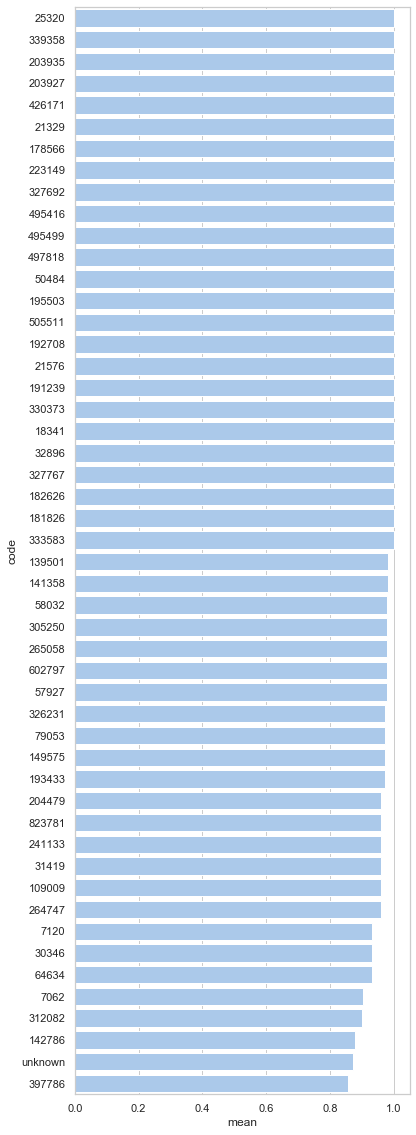

In [9]:
"""

Memo
---- 
1. performance plot

   perplot: https://pypi.org/project/perfplot/
"""
import seaborn as sns
import matplotlib.pyplot as plt
from analyzer import load_performance, label_by_performance
from utils_sys import size_hashtable

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 20))
sns.set_color_codes("pastel")

#---------------------------------------------

# load performance data
cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
print("> dim(performance matrix): {}".format(df_perf.shape))

# sort ~ performance scores 
# df_perf = df_perf.sort_values(by=['mean', ], ascending=False)

categories = ['easy', 'hard', 'low']
ccmap = label_by_performance(cohort=cohort, categories=categories)
N = size_hashtable(ccmap)
N_easy = len(ccmap['easy'])
N_hard = len(ccmap['hard'])
N_low = len(ccmap['low'])
print("[analysis] N(codes; cohort={}): {}".format(cohort, N))
print("...        n(easy): {} | ratio: {}".format(N_easy, N_easy/(N+0.0)))
print("...        n(hard): {} | ratio: {}".format(N_hard, N_hard/(N+0.0)))
print("...        n(low):  {} | ratio: {}".format(N_low,  N_low/(N+0.0)))

header = ['code', 'mean', 'std', 'n_pos']
codes = df_perf['code']
n_codes = len(codes)
scores = df_perf['mean']

# some statistics
score_high = 0.90
score_low = 0.50

codes_low_sz = ccmap['low']
codes_scored = np.hstack( [ccmap['easy'], ccmap['hard']] )
codes_high_score = ccmap['easy']
assert n_codes == len(codes_low_sz) + len(codes_scored)

print("1. Total number of codes: {} | n(low_sample): {}, n(scored):{}, n(high scored):{}".format(n_codes, 
   len(codes_low_sz), len(codes_scored), len(codes_high_score)))

r_scored = len(codes_scored)/(n_codes+0.0)
rh = len(codes_high_score)/(n_codes+0.0)
print("2. Fraction of scored codes: {}".format(r_scored))
print("3. Fraction of highly scored codes: {}".format(rh))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)
# print(df_botn)

# codes = [str(c) for c in df_botn['code'].values]
# print('lower codes: {}'.format(codes))
# scores = df_botn['mean'].values
# print('scores: {}'.format(scores))

# top n + bottom n
dfe = pd.concat([df_topn, df_botn], ignore_index=True)
dfe.sort_values(by=['mean', ], ascending=False, inplace=True)
codes = [str(c) for c in dfe['code'].values]
scores = dfe['mean'].values
# print('lower(n)+higher codes(n): {}'.format(codes))
# print('scores: {}'.format(scores))
print(dfe)

# sns.barplot(x="total", y="abbrev", data=crashes,
#             label="Total", color="b")

# --------------------
# ax = sns.barplot(x='mean', y='code', data=df_botn)
# print("-------------------------\n\n")
# print("> dtype: {}".format(df_botn.dtypes))
# print(df_botn.head(10))

# dfe = dfe[['mean', 'code']]
# dfe.plot(kind='bar')

sns.barplot(x='mean', y='code', data=dfe, order=dfe['code'], # order has to be specified; even if already sorted!!!
            label="LOINC", color="b", orient='h')

# ax = sns.barplot(x='mean', y='code', data=df)

# ax.set_xlabel('Fmax Score')
# ax.set_ylabel('LOINC')